## PERFORMANCE ANALYSIS OF UAV GPS SYSTEMS UNDER SPOOFING ATTACK USING DISCRETE MARKOV CHAIN
This analysis was conducted as part of the Systems Performance Analysis course for a Master's degree. The final research paper generated from this notebook is also included in the repository for further details.
### 1. Objective
This notebook performs a comprehensive performance and security analysis of a GPS system under spoofing conditions. Using a public dataset designed for spoofing detection research, we employ a Discrete-Time Markov Chain (DTMC) to model the sequence of transitions between a "Safe" operational state and three distinct "Attack" states. The goal is to quantitatively assess the system's resilience and vulnerabilities based on the observed event patterns.

### 2. Methodology Overview
The analysis treats the cleaned dataset as a sequence of discrete steps, focusing on the probability of moving from one state to another rather than the real-time duration. The core of this notebook involves:
1. Calculating the Transition Probability Matrix (P) to describe the system's step-by-step dynamics.
2. Solving for the Steady-State Probabilities (π) to understand the long-run behavior.
3. Deriving key performance metrics such as System Utilization (U), Average Attack Severity (N), and Mean Recurrence Time (W).

### 3. Notebook Workflow
The notebook is structured to follow a clear data analysis:
1. Initial Loading & Sanitization: The raw dataset is loaded, and data types are corrected.
2. Data Cleaning & Filtering: A multi-step process is applied to resolve duplicate timestamps and distill the data into a single, unambiguous sequence of events.
3. DTMC Parameter Calculation: The core analysis cell calculates the P-matrix and the steady-state probabilities.
3. Visualization: The final cells generate a series of professional visualizations to present the results, including a state transition diagram, a styled P-matrix table, and a bar chart of the steady-state probabilities.

##### Resources
Aissou, Ghilas (2022). A DATASET for GPS Spoofing Detection on Unmanned Aerial System, Mendeley Data, V3, doi: 10.17632/z7dj3yyzt8.3

### Initial Data Loading and Type Conversion

In [91]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

#### Data Loading
The delimiter=";" argument is specified, as the columns in the source file are separated by semicolons rather than commas.

#### Data Type Sanitization
1. Iterate through every column to identify any that were imported as text (object type).
2. Standardize the number format by replacing all comma decimals (,) with periods (.).
3. Convert the entire column to a numeric data type.

In [92]:
# read dataset and adjust delimiters for reading
df = pd.read_csv("GPS_Data_Simplified_2D_Feature_Map.csv", delimiter=";")

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col].str.replace(",", ".", regex=False), errors="coerce")
print(df.shape)
df.head(10)

(510530, 14)


,PRN,DO,PD,RX,TOW,CP,EC,LC,PC,PIP,PQP,TCD,CN0,Output
0,6,1160.671408,-238359.5433,491568.00,491568.0008,-24660.26329,163521.78,170008.81,179294.97,178420.33,-17688.17800,1158.4806,49.412529,0
1,6,1157.827808,-238363.9212,491568.02,491568.0208,-24683.46852,158277.05,160253.09,182106.11,182106.05,158.33333,1160.7948,49.452686,0
2,6,1161.135932,-238368.6386,491568.04,491568.0408,-24706.68736,184442.36,193125.89,208228.02,-205198.30,35391.59000,1157.6909,49.480145,0
3,6,1161.156617,-238373.3918,491568.06,491568.0608,-24729.92004,159812.45,169960.55,187550.72,187543.00,-1701.94400,1161.1343,49.433769,0
4,6,1160.690893,-238378.1271,491568.08,491568.0808,-24753.15400,183557.66,191912.58,208403.50,208330.05,-5532.89990,1161.1759,49.391670,0
5,6,1160.807697,-238382.7373,491568.10,491568.1008,-24776.37474,178968.47,184958.66,198938.81,198488.98,-13370.64100,1160.6908,49.290367,0
6,6,1163.400529,-238386.9722,491568.12,491568.1208,-24799.60779,168080.86,173257.44,185404.97,-184959.58,12843.65700,1160.6932,49.303074,0
7,6,1159.350641,-238391.2251,491568.14,491568.1408,-24822.83854,153961.95,162982.91,169926.69,169467.23,12487.34200,1163.5721,49.371311,0
8,6,1161.657926,-238395.2635,491568.16,491568.1608,-24846.06411,178182.84,177790.19,194533.20,-192402.30,28714.55300,1159.2557,49.421207,0
9,6,1161.995499,-238399.5520,491568.18,491568.1808,-24869.29044,160029.16,160199.95,180339.83,-180306.16,3484.41430,1161.6427,49.396267,0


#### Add labels to identify the three types of attack

In [93]:
df['State'] = df['Output'].map({
    0: 'Safe',
    1: 'SimplisticAttack',
    2: 'IntermediateAttack',
    3: 'SophisticatedAttack'
})

#### Chronological Sorting of the Dataset
The DataFrame is sorted using a two-level key to achieve a highly granular temporal order:
1. Primary Key (TOW): The data is first sorted by the "Time of the Week" column.
2. Secondary Key (RX): For any entries that share the exact same TOW, the "Receiver Time" (RX) is used as a tie-breaker to sort them.
After sorting, the DataFrame's index is reset using `.reset_index(drop=True)` to create a new, clean, and sequential index starting from 0.

In [94]:
df = df.sort_values(by=['TOW', 'RX'], ascending=True).reset_index(drop=True)
print(df.head(10))

   PRN           DO           PD         RX         TOW           CP  \
0   26 -1407.495077 -2397690.634  173640.00  173640.008  37759.75100   
1   26 -1406.742979 -2397690.634  173640.00  173640.008  37759.75100   
2   26 -1405.308935 -2397685.166  173640.02  173640.028  37787.93074   
3   26 -1406.774068 -2397685.166  173640.02  173640.028  37787.93074   
4   26 -1406.987716 -2397679.895  173640.04  173640.048  37816.12306   
5   26 -1408.696630 -2397679.895  173640.04  173640.048  37816.12306   
6   26 -1405.867855 -2397674.499  173640.06  173640.068  37844.30873   
7   26 -1406.626045 -2397674.499  173640.06  173640.068  37844.30873   
8   26 -1407.427479 -2397669.183  173640.08  173640.088  37872.48590   
9   26 -1409.272073 -2397669.183  173640.08  173640.088  37872.48590   

             EC           LC           PC           PIP            PQP  \
0  125018.70310  145129.7344  152941.6406  152666.25000    9173.994141   
1  125018.70310  145129.7344  152941.6406  152666.25000    

#### State Population and Utilization Analysis
Calculates both the absolute number of samples for each state and their percentage relative to the total dataset size.
1. Calculate the total number of samples (rows) in the DataFrame.
2. Use `.value_counts()` method is used on the State column to count the number of occurrences for each unique state value (0, 1, 2, 3).
3. Divide its population count by the total number of samples, and the result is converted to a percentage.

In [95]:
# Population count - number of samples for each state
total_samples = len(df)
population = df['State'].value_counts()
utilization = (population / total_samples) * 100

summary_table = pd.DataFrame({
    'Sample Count': population,
    'Percentage (%)': utilization.round(2)
})
display(summary_table)

,Sample Count,Percentage (%)
State,,
Safe,397825,77.92
IntermediateAttack,44232,8.66
SimplisticAttack,36458,7.14
SophisticatedAttack,32015,6.27


#### Data Filtering and Duplicate Timestamp Resolution
Cleaning and selection logic. Transforms the full, sorted dataset into the final, condensed version that will be used for the Markov chain analysis.
- **Goal:** Ensure each timestamp (TOW) is unique and represents the single most relevant data point for that moment in time.

##### Feature Selection and Initial Cleaning
1. Narrow down the DataFrame to only the essential columns required for the analysis.
2. Performs a final data integrity check by ensuring the Output column is numeric.
3. Drop any remaining rows that might have missing values.

##### Duplicate Resolution Logic
Select the single best entry for each duplicate timestamp. A three-level sorting method is applied:
1. Chronological Order (TOW): The data is sorted by time.
2. Signal Quality (CN0): Within each time group, rows are sorted by their Carrier-to-Noise ratio in descending order, prioritizing signals that are stronger and more reliable.
3. Attack Priority (Output): As a final tie-breaker for rows with the same timestamp and signal strength, rows are sorted by their Output state in descending order. This ensures that an "attack" state is prioritized over a "safe" state.

After this precise sorting, the `.drop_duplicates()` command is used to keep only the first row for each unique TOW. Because of the sorting, this first row is guaranteed to be the most relevant one according to our defined hierarchy.

In [96]:
# Remove unnecessary columns
columns_to_keep = ['TOW', 'RX', 'PRN', 'CN0', 'Output']
df = df.loc[:, columns_to_keep]
df['Output'] = pd.to_numeric(df['Output'], errors='coerce')
df.dropna(inplace=True)

# Handle Duplicate Timestamps
df = df.sort_values(
    by=['TOW', 'CN0', 'Output'],
    ascending=[True, False, False]
)

# Drop duplicates
df_cleaned = df.drop_duplicates(subset=['TOW'], keep='first')

# Sort the final dataset by time and reset the index for a clean output
df = df_cleaned.sort_values(by='TOW').reset_index(drop=True)

print(f"Final cleaned dataset has {len(df)} rows.")

Final cleaned dataset has 434613 rows.


#### Discrete-Time Markov Chain (DTMC) Analysis
Core analytical code. Perform the complete DTMC analysis to derive all key parameters and performance metrics for the system.

##### Transition Probability Matrix (P) Estimation
1. Count the total number of times the system was observed in each state (state_counts).
2. Iterate through the entire dataset sequentially to count every transition from a starting state `i` to an ending state `j`. Store them in the transition_counts matrix.
3. Calculate the probabilities by dividing the number of `i → j` transitions by the total number of times the system was in state `i`.

In [97]:
# Calculate the Transition Probability Matrix (P)
possible_states = sorted(df['Output'].unique().astype(int))
state_counts = df['Output'].value_counts().reindex(possible_states, fill_value=0)
transition_counts = pd.DataFrame(0, index=possible_states, columns=possible_states)
for i in range(1, len(df)):
    start_state = int(df.loc[i-1, 'Output'])
    end_state = int(df.loc[i, 'Output'])
    if start_state in possible_states and end_state in possible_states:
        transition_counts.loc[start_state, end_state] += 1

# Calculate the P-matrix by normalizing the transition counts
p_matrix = transition_counts.div(state_counts, axis=0).fillna(0)

print("--- Transition Probability Matrix (P) ---")
with pd.option_context('display.float_format', '{:,.4f}'.format):
  print(p_matrix)

--- Transition Probability Matrix (P) ---
       0      1      2      3
0 0.8310 0.0568 0.0779 0.0343
1 0.7571 0.0775 0.1655 0.0000
2 0.6313 0.1574 0.2113 0.0000
3 0.3929 0.0000 0.0000 0.6071


#### Steady-State Probability (π) Calculation
Calculate the long-run behavior of the system.
1. Finds the steady-state probability vector π
2. Solve the eigenvector equation `πP = π` using standard linear algebra methods available in the NumPy library.

#### Performance Metrics Calculation and Output
Use the calculated π vector to derive the key performance indicators for the system.
1. Utilization (U): The probability of the system being in any attack state.
2. Average Attack Severity (N): A weighted average of the system's state, indicating its overall risk level.
3. Mean Recurrence Time (W): The average number of steps it takes to return to a state after leaving it.

In [98]:
# --- Calculate Steady-State Probabilities (π) ---
eigen_matrix = p_matrix.transpose() - np.identity(len(possible_states))
A = np.vstack((eigen_matrix[:-1], np.ones(len(possible_states))))
b = np.zeros(len(possible_states))
b[-1] = 1
pi = np.linalg.solve(A, b)

# --- Display DTMC Performance Metrics ---
print("--- DTMC Performance Analysis ---")
print("\nSteady-State Probabilities (π):")
for i, p in enumerate(pi):
    print(f"  π({i}): {p:.4f}  (System is in State {i} for {p:.2%} of the steps)")

utilization = 1 - pi[0]
print(f"\nUtilization (U): {utilization:.4f}")

avg_severity = np.sum(pi * np.array(possible_states))
print(f"\nAverage Attack Severity (N): {avg_severity:.4f}")

print("\nMean Recurrence Time (W) per State:")
for i in possible_states:
    recurrence_time = 1 / pi[i] if pi[i] > 0 else float('inf')
    print(f"  State {i}: {recurrence_time:.2f} steps (on average, to return to this state)")

--- DTMC Performance Analysis ---

Steady-State Probabilities (π):
  π(0): 0.7785  (System is in State 0 for 77.85% of the steps)
  π(1): 0.0633  (System is in State 1 for 6.33% of the steps)
  π(2): 0.0902  (System is in State 2 for 9.02% of the steps)
  π(3): 0.0680  (System is in State 3 for 6.80% of the steps)

Utilization (U): 0.2215

Average Attack Severity (N): 0.4477

Mean Recurrence Time (W) per State:
  State 0: 1.28 steps (on average, to return to this state)
  State 1: 15.79 steps (on average, to return to this state)
  State 2: 11.09 steps (on average, to return to this state)
  State 3: 14.70 steps (on average, to return to this state)


#### State Transition Diagram Visualization
Create a visual representation of the system's dynamics.

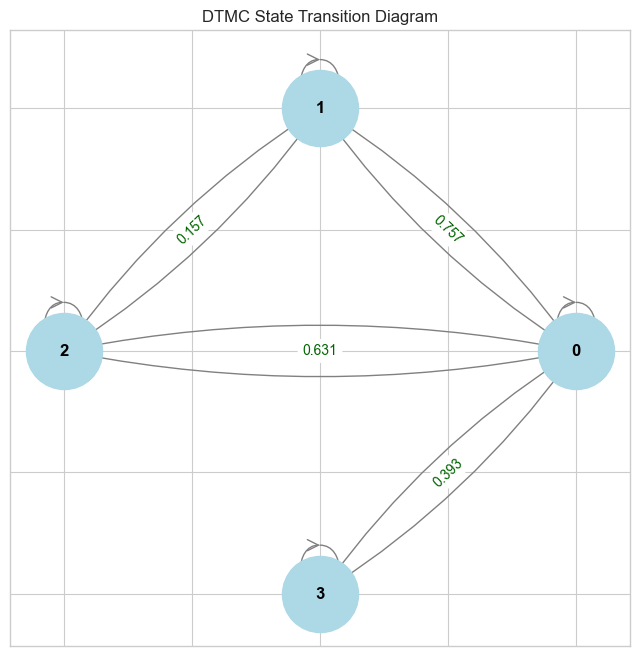

In [99]:
G = nx.DiGraph()
for start_state, row in p_matrix.iterrows():
    for end_state, prob in row.items():
        if prob > 0.001:
            G.add_edge(start_state, end_state, weight=prob)

pos = nx.circular_layout(G)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='gray',
                       arrows=True, arrowstyle='->', arrowsize=20,
                       connectionstyle='arc3,rad=0.1')

edge_labels = nx.get_edge_attributes(G, 'weight')
formatted_edge_labels = {k: f"{v:.3f}" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels,
                             font_color='darkgreen', font_size=10)

plt.title("DTMC State Transition Diagram", size=12)
plt.show()

#### Bar Chart Visualization of Steady-State Probabilities
Compare long-run probability of the system being in each of its operational states.

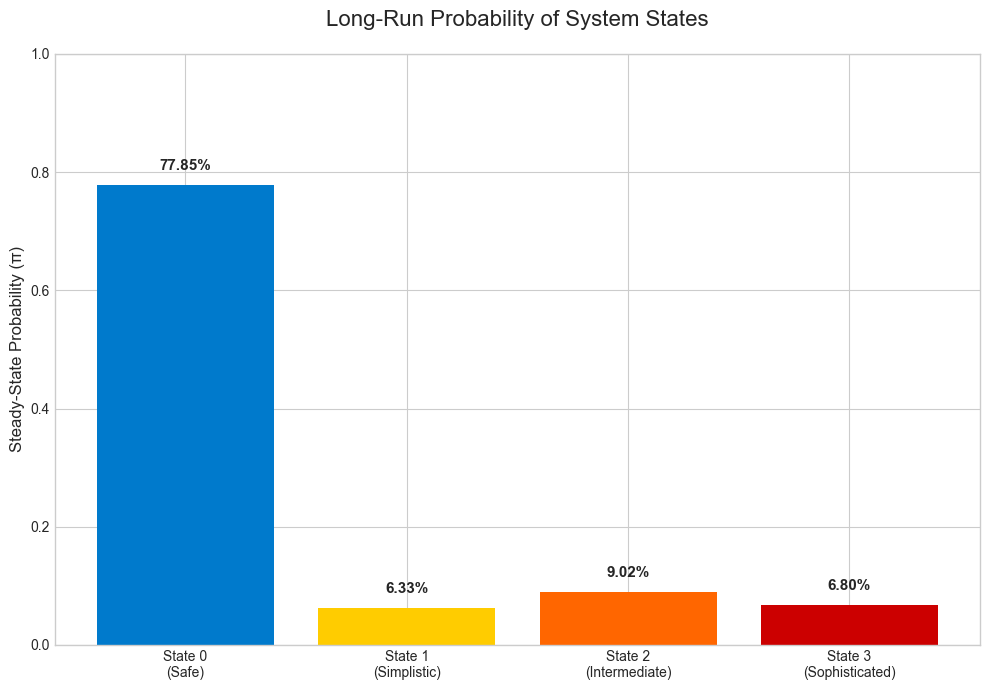

In [100]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(state_labels, pi_values, color=colors)

ax.set_ylabel('Steady-State Probability (π)', fontsize=12)
ax.set_title('Long-Run Probability of System States', fontsize=16, pad=20)
ax.set_ylim(0, 1.0)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval*100:.2f}%',
            ha='center', va='bottom', fontsize=11, weight='bold')

plt.tight_layout()
plt.show()
# plt.savefig('gps_steadystate_chart.png', dpi=300)

#### Styled Table Visualization of the P-Matrix
Visualization with color-coding (a heatmap) to make the transition probabilities intuitive and easy to interpret at a glance.

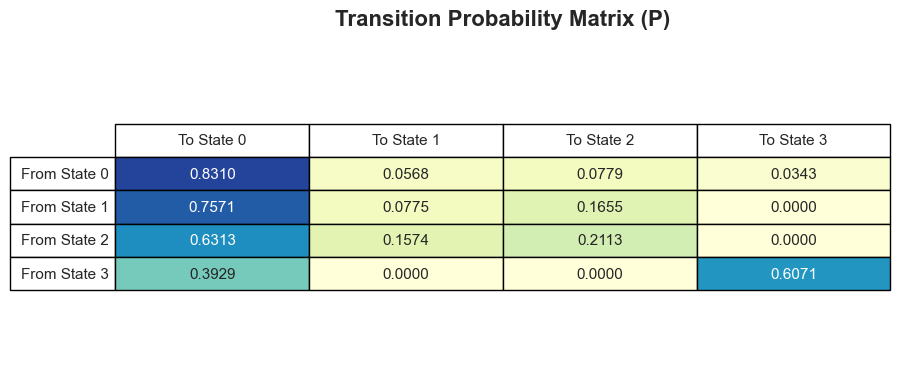

In [101]:
row_labels = [f'From State {i}' for i in p_matrix.index]
col_labels = [f'To State {i}' for i in p_matrix.columns]

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
cell_text = [[f'{prob:.4f}' for prob in row] for row in p_matrix.values]

the_table = ax.table(cellText=cell_text,
                     rowLabels=row_labels,
                     colLabels=col_labels,
                     cellLoc='center',
                     loc='center')

the_table.scale(1, 2)
the_table.auto_set_font_size(False)
the_table.set_fontsize(11)
cmap = plt.get_cmap('YlGnBu')
cells = the_table.get_celld()

for i in range(len(p_matrix.columns)):
    for j in range(len(p_matrix.index)):
        cell = cells[(j + 1, i)]
        prob = p_matrix.iloc[j, i]
        cell.set_facecolor(cmap(prob))
        if prob > 0.5:
            cell.get_text().set_color('white')

plt.title('Transition Probability Matrix (P)', fontsize=16, weight='bold', pad=20)
plt.show()
# plt.savefig('gps_pmatrix_table.png', dpi=300, bbox_inches='tight')